# Fake News Detection

<img src="images/fake_news.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary
This project uses text data from over 44,000 articles to develop a text classification model that can accurately identify fake news articles. The data consists of both fake and real news articles from several online publications, primarily Reuters and BuzzFeed. The model is being developed for a the social media company facebook, who is looking to reduce misinformation on their platform. Doing so will improve their customer experience, and reduce the possibility of any legal issues. The data was loaded and cleaned using the pandas library and split into training, testing, and validation datasets using sklearn. After establishing a baseline model, multiple iterations are developed using different data processing techniques from the nltk library such as stopword removal, stemming, and tokenization. Additional feature engineering approaches are taken such as part-of-speech tags, bigrams, and mutual information scores. Lastly, several different classifiers are evaluated. Each model is evaluated based on its training and validation accuracies. The baseline tfidf vectorizer/naive bayes model obtained a 63% accuracy in identifying fake and real news. The final model uses count vectorization and an xgboost classifier, and obtained an accuracy of 96%.

## Business Problem
The social media company facebook is looking to reduce the sharing of misinformation on its platform. Having widespread misinformation on the platform may discourage new users and may cause the platform to lose existing customers. Additionally, reducing fake articles on the platform could remove any potential legal issues.

## Data Understanding
This project uses three datasets consisting of 44,706 news articles from online publications, primarily Reuters and BuzzFeed. The data can be found on Kaggle with the follwing two links, [Link1](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset) [Link2](https://www.kaggle.com/datasets/hassanamin/textdb3). The data is fairly balanced, having about 54% of the data being real news articles and 46% being fake articles.

In [92]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
from sklearn.metrics import confusion_matrix, mutual_info_score
import seaborn as sn
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [93]:
# load datasets
fake_or_real_df_1 = pd.read_csv('Data/fake_or_real_news.csv')
fake_df_2 = pd.read_csv('Data/Fake.csv')
true_df_2 = pd.read_csv('Data/True.csv')

In [94]:
# preview first df
fake_or_real_df_1.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [95]:
# preview second df
fake_df_2.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [96]:
# preview third df
true_df_2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [97]:
# select desired columns from each dataframe
fake_or_real_df_1 = fake_or_real_df_1[['text', 'label']]

fake_df_2 = fake_df_2[['text']]
true_df_2 = true_df_2[['text']]

# create label columns
fake_df_2['label'] = 'FAKE'
true_df_2['label'] = 'REAL'

In [98]:
# combine all three datasets
fake_or_real_df = pd.concat([fake_or_real_df_1, fake_df_2, true_df_2])

In [99]:
# check for duplicates
fake_or_real_df.duplicated().any()

True

In [100]:
# check for missing values
fake_or_real_df.isna().any()

text     False
label    False
dtype: bool

In [101]:
# remove duplicate data points
fake_or_real_df.drop_duplicates(inplace=True)

In [102]:
# preview final full dataset
fake_or_real_df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,REAL
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",REAL
21414,MINSK (Reuters) - In the shadow of disused Sov...,REAL
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,REAL


In [103]:
# check class balance of final dataset
fake_or_real_df.label.value_counts(normalize=True)

REAL    0.540889
FAKE    0.459111
Name: label, dtype: float64

Real Articles:  24181
Fake Articles:  20525


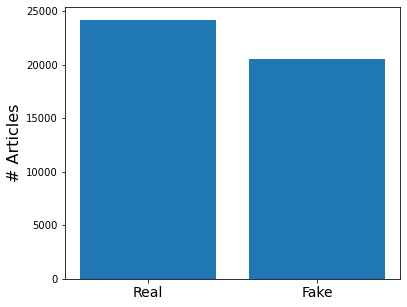

In [108]:
# plot the class distribution
counts = fake_or_real_df.label.value_counts()
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Real', 'Fake'], counts);
plt.ylabel('# Articles', fontsize=16);
plt.xticks(fontsize=14)
print("Real Articles: ", counts[0])
print("Fake Articles: ", counts[1])

## Data Preparation and Exploration
The data is split into a train, test, and validation sets. The test set will be set aside for evaluation of the final model. After splitting, the training data is standardized and tokenized for initial evaluation of word frequency distributions.

### Data Splitting

In [119]:
# define featrues and target variables
X = fake_or_real_df['text']
y = fake_or_real_df['label']

In [120]:
# intial split of data into traiing and test sets with 15% test size
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=.15, 
                                                        random_state=42)

In [121]:
# second split of data into training and validation sets with 15% val size
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, 
                                                  test_size=0.15,
                                                  random_state=42)

In [122]:
# display dataset sizes
print("Training Size: ", len(X_train))
print("Test Size: ", len(X_test))
print("Validation Size: ", len(X_val))

Training Size:  32300
Test Size:  6706
Validation Size:  5700


### Exploratory Data Analysis
A copy of the training data is created for exploratory data analysis. The word frequency of this training data is explored. The data is first standardized to lowercase and then tokenized using a custom tokenizer.

In [123]:
# reconstruct X_train to include labels for eda
eda_X_train = pd.DataFrame(X_train)
eda_y_train = pd.DataFrame(y_train)

# reset new df indexes
eda_X_train.reset_index(inplace=True, drop=True)
eda_y_train.reset_index(inplace=True, drop=True)

# add label column back to X_train df
eda_X_train['label'] = eda_y_train

In [124]:
# Transform  data to lowercase and add tokenized data to df
eda_X_train['text'] = eda_X_train['text'].str.lower()

# Tokenize data using custom pattern
token_pattern = r"(?u)\b\w\w+\b"

#instantiate tokenizer
tokenizer = RegexpTokenizer(token_pattern)

# create new column for tokenized data
eda_X_train['tokenized'] = eda_X_train['text'].apply(tokenizer.tokenize)

In [125]:
eda_X_train.head()

,text,label,tokenized
0,"during his bizarre rally in youngstown, ohio...",FAKE,"[during, his, bizarre, rally, in, youngstown, ..."
1,washington (reuters) - president donald trump ...,REAL,"[washington, reuters, president, donald, trump..."
2,the woman whose criminal investigation has bee...,FAKE,"[the, woman, whose, criminal, investigation, h..."
3,tune in to the alternate current radio network...,FAKE,"[tune, in, to, the, alternate, current, radio,..."
4,copenhagen (reuters) - danish police have char...,REAL,"[copenhagen, reuters, danish, police, have, ch..."


In [126]:
# define function for plotting top 10 words of freq dist for real and fake data
def top_10_comparison(column, title):

    #define freq distributions for fake and real datasets
    real_freq_dist = FreqDist(eda_X_train.loc[eda_X_train.label == 'REAL',
                                              column].explode())
    fake_freq_dist = FreqDist(eda_X_train.loc[eda_X_train.label == 'FAKE',
                                              column].explode())
    
    # Extract data for plotting
    real_top_10 = list(zip(*real_freq_dist.most_common(10)))
    real_tokens = real_top_10[0]
    real_counts = real_top_10[1]
    
    fake_top_10 = list(zip(*fake_freq_dist.most_common(10)))
    fake_tokens = fake_top_10[0]
    fake_counts = fake_top_10[1]
    

    # Set up plot and plot data
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].bar(real_tokens, real_counts)
    ax[1].bar(fake_tokens, fake_counts)
    
    fig.suptitle(title)
    # Customize plot appearance
    ax[0].set_title("Real News")
    ax[0].set_ylabel("Count")
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].tick_params(axis="x", rotation=45)
    
    ax[1].set_title("Fake News")
    ax[1].set_ylabel("Count")
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].tick_params(axis="x", rotation=45)

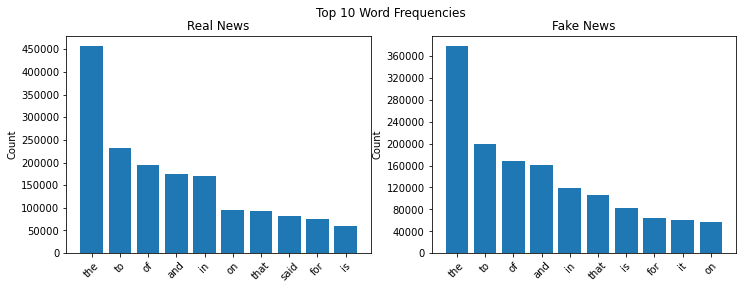

In [127]:
top_10_comparison('tokenized', "Top 10 Word Frequencies")

## Baseline Modeling
A baseline naive bayes model using tfidf vectorization is developed for comparison to future iterations.

In [144]:
# Instantiate a vectorizer with max_features=10
baseline_tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train and transform train and val sets
baseline_tfidf.fit(X_train)
X_train_vectorized_baseline = baseline_tfidf.transform(X_train)
X_val_vectorized_baseline = baseline_tfidf.transform(X_val)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_baseline, 
                                  columns=baseline_tfidf.get_feature_names())

,and,for,in,is,it,of,on,that,the,to
0,0.114623,0.188936,0.401468,0.064438,0.235747,0.255999,0.000000,0.306879,0.688845,0.309906
1,0.082231,0.090363,0.164580,0.000000,0.096644,0.244873,0.166211,0.000000,0.869757,0.323387
2,0.251063,0.137944,0.502484,0.141140,0.000000,0.124605,0.126866,0.000000,0.482814,0.617088
3,0.537835,0.344760,0.179406,0.050392,0.052675,0.355910,0.045296,0.000000,0.646438,0.088130
4,0.092909,0.000000,0.743799,0.000000,0.000000,0.092223,0.093896,0.000000,0.536013,0.365376
...,...,...,...,...,...,...,...,...,...,...
32295,0.287858,0.148857,0.152504,0.076153,0.019901,0.336157,0.085564,0.145069,0.732672,0.432840
32296,0.087491,0.000000,0.175107,0.295109,0.000000,0.347382,0.088421,0.093695,0.841264,0.172036
32297,0.293667,0.126777,0.251894,0.070753,0.024653,0.301910,0.180193,0.179709,0.746270,0.340279
32298,0.000000,0.000000,0.556625,0.625388,0.000000,0.000000,0.000000,0.000000,0.000000,0.546862


In [145]:
# Instantiate a MultinomialNB classifier and fit to the vectorized data
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized_baseline, y_train)

MultinomialNB()

In [146]:
# define funtion to print the training and validation accuracies of a model
def print_train_val_acc(model, vec_X_train, vec_X_val):
    train_preds = model.predict(vec_X_train)
    val_preds = model.predict(vec_X_val)
    
    print("train acc: ", accuracy_score(y_train, train_preds))
    print("val acc: ", accuracy_score(y_val, val_preds))

In [91]:
print_train_val_acc(baseline_model, 
                    X_train_vectorized_baseline,
                    X_val_vectorized_baseline)

train acc:  0.6348297213622291
val acc:  0.6319298245614036


At 63%, the baseline model is better than random guessing, but still leaves much room for improvement. \

## Removing Stopwords
The top 10 words of the original dataset consisted of mostly common stopwords for the real and fake news articles. Thus, this next model will use data that has common stopwords removed that often have no impact on differentiating texts.

In [128]:
# dowload and define a list of stopwords using nltk library
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

### Updated frequency distributions
The word frequencies are again graphed with no stopwords.

In [129]:
# define function to remove stopwords from tokenized data
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list 
                         if token not in stopwords_list]
    return stopwords_removed

In [130]:
# create new column with stopwords removed from tokenized training data
eda_X_train["text_without_stopwords"] = eda_X_train["tokenized"].apply(remove_stopwords)

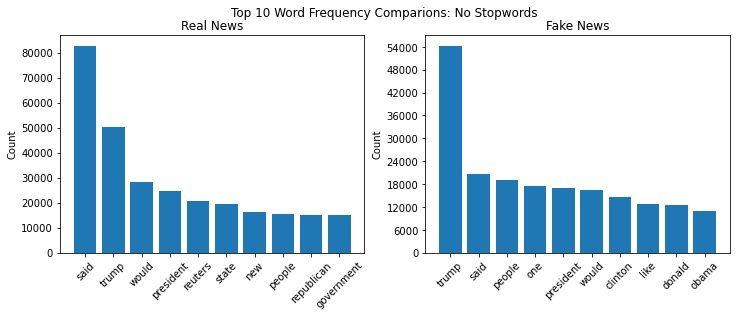

In [131]:
top_10_comparison('text_without_stopwords', "Top 10 Word Frequency Comparions: No Stopwords")

With the stopwords removed, the top 10 words for fake and real news start to differentiate.

### Model 2

In [123]:
# Instantiate the vectorizer with removal of stopwords
tfidf_2 = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)
# Fit the vectorizer on X_train and transform train and val sets
tfidf_2.fit(X_train)
X_train_vectorized_2 = tfidf_2.transform(X_train)
X_val_vectorized_2 = tfidf_2.transform(X_val)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_2, 
                                  columns=tfidf_2.get_feature_names())

,also,clinton,new,one,people,president,said,state,trump,would
0,0.000000,0.000000,0.000000,0.099169,0.000000,0.186825,0.000000,0.000000,0.977375,0.000000
1,0.269183,0.000000,0.000000,0.000000,0.000000,0.729911,0.574426,0.000000,0.254568,0.000000
2,0.000000,0.890351,0.219306,0.000000,0.398973,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.484342,0.499764,0.000000,0.718087,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
32295,0.234127,0.000000,0.000000,0.673973,0.463622,0.000000,0.166539,0.267925,0.000000,0.420096
32296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
32297,0.316555,0.000000,0.344564,0.151876,0.470135,0.000000,0.675514,0.000000,0.000000,0.283999
32298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [124]:
# Instantiate a MultinomialNB classifier and fit to data
model_2 = MultinomialNB()
model_2.fit(X_train_vectorized_2, y_train)

MultinomialNB()

In [125]:
print_train_val_acc(model_2, 
                    X_train_vectorized_2,
                    X_val_vectorized_2)

train acc:  0.7428792569659443
val acc:  0.7371929824561404


Removing the stopwords showed significant improvement over the baseline model, and thus will be included in all future models.

## Stemming and Tokenization
The data for model three is stemmed and uses the custom tokenizer that was instantiated earlier in addition to removing stopwords. 

In [132]:
# define stemmer
stemmer = SnowballStemmer(language="english")

# define fucntion to stem and tokenize
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [133]:
# stem the stopwords list 
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [134]:
# add stemmed and tokeinzed data column
eda_X_train["stemmed_and_tokenized"] = eda_X_train["text"].apply(stem_and_tokenize)
eda_X_train["stemmed_and_tokenized"] = eda_X_train["stemmed_and_tokenized"].apply(remove_stopwords)

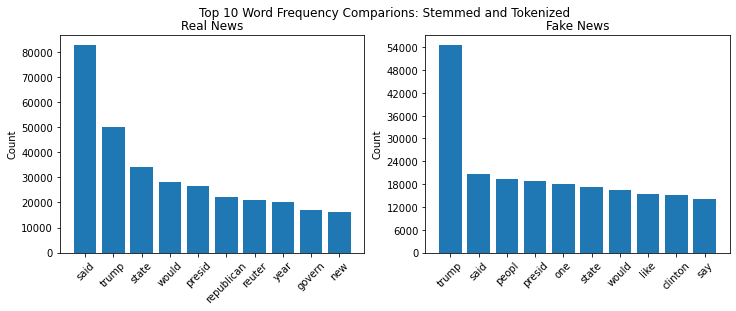

In [135]:
top_10_comparison('stemmed_and_tokenized', "Top 10 Word Frequency Comparions: Stemmed and Tokenized")

### Model 3

In [136]:
# Instantiate the vectorizer with stemming, tokeinzation, and stopword removal
tfidf_3 = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train text
tfidf_3.fit(X_train)
X_train_vectorized_3 = tfidf_3.transform(X_train)
X_val_vectorized_3 = tfidf_3.transform(X_val)

In [137]:
# Instantiate a MultinomialNB classifier
model_3 = MultinomialNB()
model_3.fit(X_train_vectorized_3, y_train)

MultinomialNB()

In [138]:
print_train_val_acc(model_3, X_train_vectorized_3, X_val_vectorized_3)

train acc:  0.7479876160990712
val acc:  0.7407017543859649


Using stemming and a custom tokenizer showed negligible improvement in the model accuracy and thus will not be included in future models.

## Model 4: Increasing Max Features
Up until this point, we have developed the model only using the top 10 most frequent features. In this model, that is increased to the top 100 features. adding more features will give the model more information to differentiate between fake and real news articles.

In [30]:
# Instantiate the vectorizer with max_features=100 and stopword removal
tfidf_4 = TfidfVectorizer(
    max_features=100,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train and transform X_train and X_val
tfidf_4.fit(X_train)
X_train_vectorized_4 = tfidf_4.transform(X_train)
X_val_vectorized_4 = tfidf_4.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_4, columns=tfidf_4.get_feature_names())

,000,2016,according,administration,also,america,american,back,bill,called,...,war,washington,way,week,well,white,world,would,year,years
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.115893,0.000000,0.000000,0.101722
1,0.0,0.000000,0.000000,0.000000,0.171296,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.213501,0.0,0.0,0.000000,0.452798,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.350121,0.158118,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.133681,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.0,0.227903,0.068616,0.000000,0.049840,0.074747,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.137125,0.000000,0.073214,0.089429,0.000000,0.000000
32296,0.0,0.000000,0.000000,0.178542,0.000000,0.000000,0.160993,0.157726,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.614996,0.000000,0.000000,0.000000,0.000000
32297,0.0,0.045879,0.041439,0.000000,0.060200,0.000000,0.000000,0.040812,0.0,0.041169,...,0.000000,0.000000,0.0,0.0,0.000000,0.517174,0.000000,0.054009,0.035034,0.116428
32298,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
# Instantiate a MultinomialNB classifier
model_4 = MultinomialNB()
model_4.fit(X_train_vectorized_4, y_train)

MultinomialNB()

In [35]:
print_train_val_acc(model_4, X_train_vectorized_4, X_val_vectorized_4)

train acc:  0.875015479876161
val acc:  0.8750877192982456


Increasing the max features significantly improved the accuracy of the model, and will be included in the next iterations.

## Model 5: Part-of-Speech Tag
Data is constructed that includes each word from the text with its part of speech. Including the function of each word may provide another layer of information that will help in separating fake and real news.

In [136]:
# define fucntion to creat tokeinzed pos-tags
def tokenize_tag(document):
    tokens = tokenizer.tokenize(document)
    return pos_tag(tokens)

In [38]:
# Instantiate the vectorizer with the pos function
tfidf_5 = TfidfVectorizer(
    max_features=100,
    stop_words=stopwords_list,
    tokenizer=tokenize_tag
)

# Fit the vectorizer on X_train and transform X_train and X_val
tfidf_5.fit(X_train)
X_train_vectorized_5 = tfidf_5.transform(X_train)
X_val_vectorized_5 = tfidf_5.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_5, columns=tfidf_5.get_feature_names())

,"(about, IN)","(after, IN)","(against, IN)","(all, DT)","(also, RB)","(an, DT)","(and, CC)","(any, DT)","(are, VBP)","(as, IN)",...,"(what, WP)","(when, WRB)","(which, WDT)","(white, JJ)","(who, WP)","(will, MD)","(with, IN)","(would, MD)","(year, NN)","(you, PRP)"
0,0.064351,0.066997,0.0,0.037371,0.000000,0.027378,0.082516,0.084252,0.086309,0.025531,...,0.072845,0.106838,0.000000,0.000000,0.057681,0.032572,0.192481,0.000000,0.000000,0.000000
1,0.000000,0.102495,0.0,0.114343,0.108216,0.000000,0.063119,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.286054,0.000000,0.000000,0.147234,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.083666,0.126084,0.000000,0.087919,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073527,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.522625,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050796,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.343583,0.064722,0.000000,0.090262,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090484,0.000000,0.226458,0.000000,0.129154,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.000000,0.049144,0.0,0.000000,0.025943,0.020082,0.257243,0.000000,0.021103,0.056184,...,0.053433,0.000000,0.024481,0.000000,0.063466,0.047784,0.070595,0.046550,0.000000,0.028915
32296,0.073366,0.076383,0.0,0.000000,0.000000,0.000000,0.047038,0.000000,0.000000,0.000000,...,0.000000,0.081204,0.000000,0.426354,0.000000,0.000000,0.000000,0.000000,0.000000,0.089883
32297,0.054546,0.056788,0.0,0.047515,0.029979,0.116032,0.244802,0.035707,0.048772,0.043282,...,0.046309,0.030186,0.014144,0.257548,0.097785,0.013804,0.122365,0.026896,0.017447,0.133651
32298,0.000000,0.000000,0.0,0.000000,0.000000,0.339633,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.441785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
# Instantiate a MultinomialNB classifier
model_5 = MultinomialNB()
model_5.fit(X_train_vectorized_5, y_train)

MultinomialNB()

In [41]:
print_train_val_acc(model_5, X_train_vectorized_5, X_val_vectorized_5)

train acc:  0.8528792569659442
val acc:  0.8517543859649123


The model performed well, but not as well as the previous model with no pos tags, thus pos tags will not be included going forward.

## Model 6: Using Bigrams
Using bigrmas, or pairs of words may give more information about the content and text of each text that could result in improved accuracy for the model. 

In [140]:
# Instantiate the vectorizer with bigrams added
tfidf_6 = TfidfVectorizer(
    max_features=100,
    ngram_range=(2,2),
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train and transform it
tfidf_6.fit(X_train)
X_train_vectorized_6 = tfidf_6.transform(X_train)
X_val_vectorized_6 = tfidf_6.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_6, columns=tfidf_6.get_feature_names())

,also said,american people,attorney general,barack obama,bernie sanders,bill clinton,climate change,clinton campaign,democratic party,donald trump,...,united states,vice president,vladimir putin,wall street,washington post,washington reuters,white house,year old,years ago,york times
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.242935,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.205322,...,0.000000,0.000000,0.0,0.0,0.0,0.317486,0.585678,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
32296,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.628055,0.000000,0.000000,0.0
32297,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.133212,0.157902,0.0
32298,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
# Instantiate a MultinomialNB classifier
model_6 = MultinomialNB()
model_6.fit(X_train_vectorized_6, y_train)

In [142]:
print_train_val_acc(model_6, X_train_vectorized_6, X_val_vectorized_6)

train acc:  0.8261609907120743
val acc:  0.8226315789473684


THe bigram based model did not improve the accuracy. Unigrams, or individual words will be used going forward.

## Count Vectorization
Thus far, we have vectorized the data using only the Tdidf vectorizer. Here, we try the count vectorizer with the same setup of the most successful tfidf model.

In [42]:
# Instantiate the count vectorizer with 
count_vec_7 = CountVectorizer(
    max_features=100,
    stop_words=stopwords_list
)

# Fit the vectorizer on X_train and transform it
count_vec_7.fit(X_train)
X_train_vectorized_7 = count_vec_7.transform(X_train)
X_val_vectorized_7 = count_vec_7.transform(X_val)

In [43]:
# Instantiate a MultinomialNB classifier
model_7 = MultinomialNB()
model_7.fit(X_train_vectorized_7, y_train)

MultinomialNB()

In [44]:
print_train_val_acc(model_7, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.8932817337461301
val acc:  0.893859649122807


The count vectorizer produced a slightly better accuracy than the tfidf, and thus will be used in the next model iterations.

## Classifiers
For all previous model, a simple Naive Bayes classifer was used. Using the the most accurate vectorizer and data features, multiple classifiers are evaluated.

### Support Vector Machine

In [293]:
#instantiate and fit a basic support vector classifier
svm = SVC(kernel='linear')
svm.fit(X_train_vectorized_7, y_train)

SVC(kernel='linear')

In [295]:
print_train_val_acc(svm, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.948266253869969
val acc:  0.9443859649122807


### Logistic Regression

In [45]:
#instantiate and fit a basic logistic regression classifier
lg = LogisticRegression()
lg.fit(X_train_vectorized_7, y_train)

LogisticRegression()

In [46]:
print_train_val_acc(lg, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9564705882352941
val acc:  0.9531578947368421


### Random Forest

In [211]:
#instantiate and fit a basic random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train_vectorized_7, y_train)

RandomForestClassifier()

In [212]:
print_train_val_acc(rf, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9996284829721362
val acc:  0.9508771929824561


### XGBoost

In [207]:
#instantiate a baseline XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_vectorized_7, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [208]:
print_train_val_acc(xgb, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9902167182662539
val acc:  0.9535087719298245


The XGBoost classifier produced the highest validation accuracy, however is slightly over-fit. A hyperparameter grid search will be run to try to further increase the validation accuracy and decrease the over-fitting.

In [300]:
#define parameter grid for search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [2,4,6],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5],
    'n_estimators': [100],
}

#insantiate and fit search object
grid_xgb = GridSearchCV(xgb,
                        xgb_param_grid,
                        scoring='accuracy',
                        cv=3, n_jobs=1,
                        refit='accuracy',
                        return_train_score=True)

grid_xgb.fit(X_train_vectorized_4, y_train)

#print best parameters
best_parameters = grid_xgb.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 2
n_estimators: 100
subsample: 0.5


In [47]:
#instantiate a XGBoost Classifier with optimal parameters
xgb2 = XGBClassifier(learning_rate=0.1,
                   max_depth=6,
                   min_child_weight=2,
                   n_estimators=100,
                   subsample=0.5)
xgb2.fit(X_train_vectorized_7, y_train)

[18:03:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
print_train_val_acc(xgb2, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9778947368421053
val acc:  0.9610526315789474


Tuning the xgboost hyperparameters did decrease the over-fitting and increase the validation accuracy. This will be the final model.

## Final Evaluation
Now that the best data features, vectorization, and classifier options have been selected, the final model is evaluated on the holdout test dataset.

In [49]:
# define final model and vectoize test datset
final_model = xgb2
X_test_vec_final = count_vec_7.transform(X_test)

In [50]:
# calculate final model testing accuracy
test_preds= final_model.predict(X_test_vec_final)

print("Final Model Test Accuracy: ", accuracy_score(test_preds, y_test))

Final Model Test Accuracy:  0.959737548464062


In [51]:
#define final model confusion matrix
final_cm = confusion_matrix(y_test, test_preds)

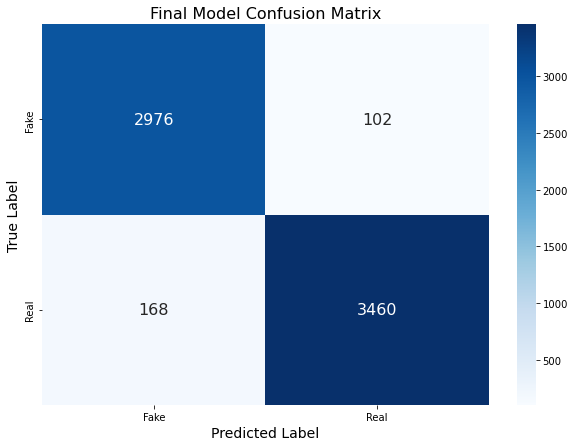

In [52]:
# plot confusion matrix of final model
df_cm = pd.DataFrame(final_cm, index = ['Fake', 'Real'],
                  columns = ['Fake', 'Real'])
fig, ax = plt.subplots(figsize=(10,7))
ax = sn.heatmap(df_cm, annot=True, annot_kws={'fontsize': 16}, cmap='Blues', fmt='g');
ax.set_xlabel('Predicted Label', fontsize=14);
ax.set_ylabel('True Label', fontsize=14);
plt.title('Final Model Confusion Matrix', fontsize=16);

In [149]:
# baseline confusion matrix for comparison to final model
baseline_preds = baseline_model.predict(X_val_vectorized_baseline)
baseline_cm = confusion_matrix(y_val, baseline_preds)

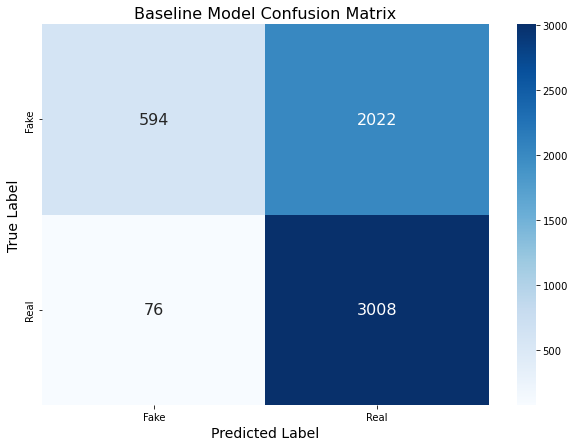

In [150]:
# plot confusion matrix of final model
df_baseline_cm = pd.DataFrame(baseline_cm, index = ['Fake', 'Real'],
                  columns = ['Fake', 'Real'])
fig, ax = plt.subplots(figsize=(10,7))
ax = sn.heatmap(df_baseline_cm, annot=True, annot_kws={'fontsize': 16}, cmap='Blues', fmt='g');
ax.set_xlabel('Predicted Label', fontsize=14);
ax.set_ylabel('True Label', fontsize=14);
plt.title('Baseline Model Confusion Matrix', fontsize=16);

## Conclusion

- **Use model to identify and remove fake news articles from platform:** With a 96% accuracy, facebook can confidently and quickly identify fake news articles being shared and remove them from the platform.
- **Provide warnings to users that fake articles have a higher rate of references of political figures:** The word frequency distributions show that fake news article reference political figures more often the real articles. 
- **Use model to provide a verification tag to real articles:** facebook can use this model to confirm the validity of shared articles and tag them as real so that users know they can trust the article.

## Next Steps
- **Expand dataset to include more news categories:** Most of the news articles used in this model relate to domestic and international politics. Expanding the dataset to include categories such as sports, science, and entertainment would be useful.
- **Further model iteration using different NLP techniques:** Other feature engineering techniques such as lemmatization and point-wise mutual information score could be used to increase the model accuracy. A neural network could be also be tried to improve classification accuracy.
- **Determine if similar model can be constructed using only article titles:** the current model uses the full text from articles. A model that uses the title could be more efficient. 